In [10]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import numpy as np
from src.telstra_data import TelstraData
import pandas as pd
import numpy as np
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from src.refined_rf import RefinedRandomForest
from src.telstra_data import TelstraData, multiclass_log_loss
from matplotlib import pyplot as plt

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
%%time
featureparams = {"location_min_count": 0,
                     "n_common_events":20,
                     "n_common_log_features":40,
                     "n_common_resources":5,
                     "n_label_encoded_events":0,
                     "n_label_encoded_log_features":4}

aggregateparams = {"loc_agg_prior_weight":3.0}
data = TelstraData(include=[], exclude=[], **featureparams)

/Users/xuanqi/Documents/GitHub/kaggle-telstra/src/telstra_data.py:202: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=9,min_periods=1,center=True).mean()
  rmean = lambda x: pd.rolling_mean(x,window=9,min_periods=1,center=True)


CPU times: user 7.14 s, sys: 237 ms, total: 7.37 s
Wall time: 7.35 s


In [15]:
%%time
y = data.get_y()
kf = StratifiedKFold(y.values, n_folds=10, shuffle=True, random_state = 1234)
for itrain, itest in kf:
    X_train, y_train, X_test, y_test = data.get_train_test_features(itrain, itest, **aggregateparams)
    break

/Users/xuanqi/Documents/GitHub/kaggle-telstra/src/telstra_data.py:330: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=2,min_periods=1,adjust=True,ignore_na=False).mean()
  return lambda x: [0]+pd.ewma(x==fs,halflife = halflife,min_periods=1)[:-1].tolist()


172
CPU times: user 3.08 s, sys: 176 ms, total: 3.25 s
Wall time: 3.2 s


/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [16]:
X_train.head()

,sevtype,location,num,numsh,numsh0,numsh1,loc_count,nevents,event_10,event_11,...,restype_7,restype_8,lastknown,nextknown,ewma02,ewma12,ewma22,loc_prob_0,loc_prob_1,loc_prob_2
id,,,,,,,,,,,,,,,,,,,,,
14121,2,118,0.010473,-0.662136,-0.541374,-0.712389,0.708070,0.428389,0.0,0.0,...,0.0,0.0,0.0,0.0,0.340798,0.051778,0.000000,1.127849,-0.983113,-0.726121
9320,2,91,0.933091,0.508098,0.566570,0.398389,0.727363,0.428389,0.0,0.0,...,0.0,0.0,0.0,0.0,0.617939,0.000003,0.000000,1.003172,-0.787020,-0.748238
14394,2,152,-0.767986,-0.693708,-0.744473,-0.665158,-0.931824,0.428389,0.0,0.0,...,0.0,0.0,0.0,0.0,0.546918,0.000000,0.000000,0.249100,0.059603,-0.484503
8218,1,931,0.615941,0.897498,0.931382,0.778990,0.167870,0.428389,0.0,1.0,...,0.0,1.0,0.0,0.0,0.286470,0.001618,0.004583,0.465525,-0.794835,0.155969
14804,1,120,-0.335509,1.654928,1.644845,1.625559,-0.796774,3.185095,0.0,1.0,...,0.0,1.0,1.0,0.0,0.149356,0.406910,0.000000,-0.670360,1.497387,-0.637837


In [19]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

## the loss function 
def computeLoss2(groud_truth,predictions):

    predictions = pd.DataFrame(predictions)
    
    eps = 1e-15
    y_true = groud_truth
    predictions = np.clip(predictions,eps,1-eps)
    predictions.div(predictions.sum(axis=1), axis=0)
    

    actual = np.zeros(predictions.shape)
    
    n_samples = actual.shape[0]
    
    actual[np.arange(n_samples),y_true.astype(int)] = 1
    
    vectsum = np.sum(actual * np.log(predictions))
    
    loss = np.sum(-1.0/n_samples*vectsum)
    return loss

0.5862748099531266
100000.0
CPU times: user 2.27 s, sys: 839 ms, total: 3.11 s
Wall time: 14min 36s


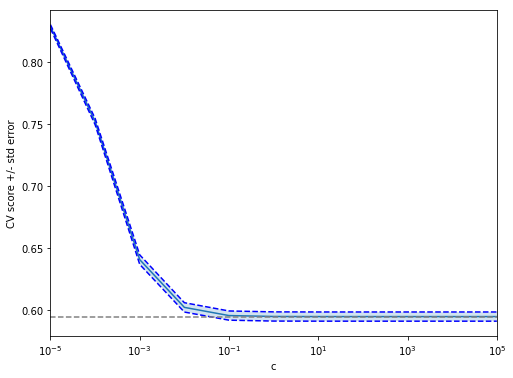

In [20]:
%%time

# logistic regression
from time import time
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def plotError(scores,scores_std,estimator,n_folds = 5):
    plt.figure().set_size_inches(8, 6)
    plt.semilogx(estimator, scores)
    # plot error lines showing +/- std. errors of the scores
    n_folds = 5
    std_error = scores_std / np.sqrt(n_folds)

    plt.semilogx(estimator, scores + std_error, 'b--')
    plt.semilogx(estimator, scores - std_error, 'b--')

    # alpha=0.2 controls the translucency of the fill color
    plt.fill_between(estimator, scores + std_error, scores - std_error, alpha=0.2)

    plt.ylabel('CV score +/- std error')
    plt.xlabel('c')
    plt.axhline(np.min(scores), linestyle='--', color='.5')
    plt.xlim([c[0], c[-1]])
    print(min(score))
    print(c[score_avg.index(min(score_avg))])
#     print(clf.best_score_)
#     print(clf.best_estimator_)


c = np.logspace(-5,5,num = 11)  #best 0.1
# c = np.linspace(0.05,0.5)
logloss = make_scorer(computeLoss2,greater_is_better=True,needs_proba = True)
score_avg = []
score_std = []
c = np.logspace(-5,5,num = 11)

for l in c:

    lr = LogisticRegression(random_state = 42,C = l,multi_class = 'multinomial',solver = 'saga',max_iter = 5000)
    score = cross_val_score(lr,X_train,y_train,cv=5,scoring = logloss,n_jobs=-1)

    score_avg.append(np.mean(score))
    score_std.append(np.std(score))

plotError(score_avg,score_std,c,n_folds = 5)
# the best is 0.5
## make score
# clf.predict_proba()

In [45]:
%%time
lr_best = LogisticRegression(random_state = 42,C =1,multi_class = 'multinomial',solver = 'saga',max_iter = 5000)
lr_best.fit(X_test,y_test)
loss = multiclass_log_loss(y_test.values,lr_best.predict_proba(X_test))
print(loss)

0.6081402377587383
CPU times: user 9.58 s, sys: 13.8 ms, total: 9.59 s
Wall time: 9.6 s


In [23]:
%%time
# random Forest
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_features=23, random_state=1)
clf.fit(X_train, y_train)
loss2tr = multiclass_log_loss(y_train.values, clf.predict_proba(X_train))
loss2te = multiclass_log_loss(y_test.values, clf.predict_proba(X_test))
print("Random Forest: train loss {:.4f}, test loss {:.4f}".format(loss2tr, loss2te))

Random Forest: train loss 0.2916, test loss 0.4513
CPU times: user 2.37 s, sys: 19.7 ms, total: 2.39 s
Wall time: 2.39 s


In [24]:
%%time
from src.refined_rf import RefinedRandomForest
from src.telstra_data import TelstraData, multiclass_log_loss

rrf = RefinedRandomForest(clf, C = 0.01, n_prunings = 0)
rrf.fit(X_train, y_train)
loss3tr = multiclass_log_loss(y_train.values, rrf.predict_proba(X_train))
loss3te = multiclass_log_loss(y_test.values, rrf.predict_proba(X_test))

print("Refined Random Forest, not pruned: train loss {:.4f}, test loss {:.4f}".format(loss3tr, loss3te))

Refined Random Forest, not pruned: train loss 0.1458, test loss 0.4612
CPU times: user 884 ms, sys: 129 ms, total: 1.01 s
Wall time: 2.08 s


In [25]:
%%time
rrf.n_prunings = 1 # do one pruning in each iteration
trainloss = [loss3tr]
testloss = [loss3te]
nleaves = [sum(rrf.n_leaves_)] # remember number of leaves in each iteration
for k in range(100):
    rrf.fit(X_train, y_train) # fit and do 1 pruning
    loss4tr = multiclass_log_loss(y_train.values, rrf.predict_proba(X_train))
    loss4te = multiclass_log_loss(y_test.values, rrf.predict_proba(X_test))
    trainloss.append(loss4tr)
    testloss.append(loss4te)
    nleaves.append(sum(rrf.n_leaves_))
#     print(nleaves)
    print("Pruning {:02d}: train loss {:.4f}, test loss {:.4f}".format(k+1, loss4tr, loss4te))
    if loss4te > 0.9:
        break # stop when test error increases too much

Pruning 01: train loss 0.1458, test loss 0.4595
Pruning 02: train loss 0.1458, test loss 0.4579
Pruning 03: train loss 0.1460, test loss 0.4567
Pruning 04: train loss 0.1466, test loss 0.4561
Pruning 05: train loss 0.1474, test loss 0.4531
Pruning 06: train loss 0.1487, test loss 0.4515
Pruning 07: train loss 0.1505, test loss 0.4500
Pruning 08: train loss 0.1525, test loss 0.4492
Pruning 09: train loss 0.1552, test loss 0.4447
Pruning 10: train loss 0.1584, test loss 0.4427
Pruning 11: train loss 0.1617, test loss 0.4433
Pruning 12: train loss 0.1656, test loss 0.4449
Pruning 13: train loss 0.1695, test loss 0.4446
Pruning 14: train loss 0.1738, test loss 0.4433
Pruning 15: train loss 0.1789, test loss 0.4410
Pruning 16: train loss 0.1843, test loss 0.4400
Pruning 17: train loss 0.1899, test loss 0.4378
Pruning 18: train loss 0.1960, test loss 0.4378
Pruning 19: train loss 0.2019, test loss 0.4383
Pruning 20: train loss 0.2082, test loss 0.4380
Pruning 21: train loss 0.2150, test loss

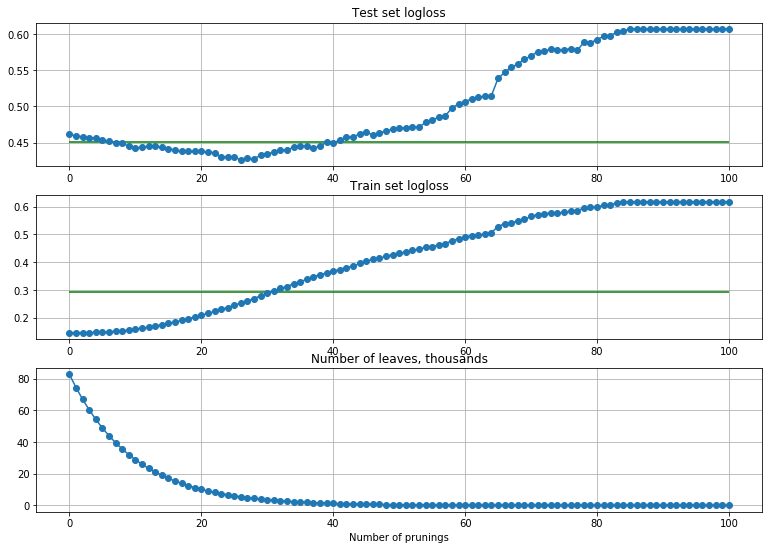

In [26]:
nprunings = np.arange(len(trainloss))
fig, ax = plt.subplots(3, figsize=(13,9))
ax[0].plot(nprunings, testloss, '-o')
ax[0].set_title('Test set logloss')
ax[0].grid()
ax[0].hlines(loss2te, nprunings.min(), nprunings.max(), colors='g', linestyles='solid')
ax[1].plot(nprunings, trainloss, '-o')
ax[1].set_title('Train set logloss')
ax[1].grid()
ax[1].hlines(loss2tr, nprunings.min(), nprunings.max(), colors='g', linestyles='solid')
ax[2].plot(nprunings, np.array(nleaves)/1000, '-o')
ax[2].set_title('Number of leaves, thousands')
ax[2].set_xlabel('Number of prunings')
ax[2].grid()

In [ ]:
# svm

In [34]:
%%time
import numpy as np
import pandas as pd

from IPython.display import Image
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import svm
from matplotlib import pyplot as plt
%matplotlib inline

logloss = make_scorer(computeLoss2,greater_is_better=True,needs_proba = True)
c = np.logspace(-2,2,num = 5)
#parameters = {'kernel': ('linear','rbf'),'C':c}
parameters = {'C':c,'gamma': [0.001, 0.01, 0.1,1,10,100,1000]}
svc = svm.SVC(probability = True,kernel = 'rbf')
clf = GridSearchCV(svc,parameters,cv=5,scoring = logloss)
clf.fit(X_train,y_train)
clf.cv_results_

CPU times: user 1h 47min 32s, sys: 19.1 s, total: 1h 47min 51s
Wall time: 1h 47min 59s


In [35]:
clf.cv_results_

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([24.33493061, 29.0802958 , 31.93481631, 32.41842761, 31.58386879,
        31.34557824, 31.44892488, 27.14845862, 30.46934967, 31.95382595,
        31.83077831, 31.90762963, 31.61661644, 31.77823911, 26.66297884,
        32.23879561, 32.01562543, 32.60034404, 32.88043795, 33.11392021,
        32.9105237 , 27.56132379, 36.0264956 , 33.94839725, 34.08022814,
        34.21661701, 33.79233608, 33.80662684, 35.97409868, 36.2026351 ,
        34.0008667 , 34.14596839, 34.08583636, 34.43389559, 33.80257797]),
 'mean_score_time': array([0.80101342, 0.96788149, 0.91965451, 0.96510077, 0.9365344 ,
        0.93680043, 0.94332681, 0.81450515, 0.85888076, 0.91323524,
        0.93476806, 0.94317889, 0.93656654, 0.93602185, 0.80452294,
        0.85088887, 0.89150033, 0.93518281, 0.9318718 , 0.93241258,
        0.93924809, 0.76571002, 0.83657842, 0.89070954, 0.93013501,
        0.93454161, 0.93765893, 0.93264165, 0.73856034, 0.83099475,
        0.89418068, 0.93389707, 0.93025022,

In [38]:
%%time
lr_best = svm.SVC(random_state = 42,C=10,gamma=0.001,kernel = 'rbf',probability = True)
lr_best.fit(X_test,y_test)
loss = multiclass_log_loss(y_test.values,lr_best.predict_proba(X_test))
print(loss)

0.37756177599251567
CPU times: user 723 ms, sys: 2.24 ms, total: 726 ms
Wall time: 725 ms
